In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
import joblib
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")
path = 'C:/Users/lnzb7292/Desktop/BPM/Power BI IC Reports/'

fichier='Input.xlsx'

sheetname = 'pred'


file = path+fichier
# DataFrame df:
df = pd.read_excel(file, sheetname)

#close_data = df.reset_index()['IP invoiced traffic Gbps']
df['Date'] = pd.to_datetime(df["Date"])
df.set_axis(df['Date'], inplace=True)
df1=df


#

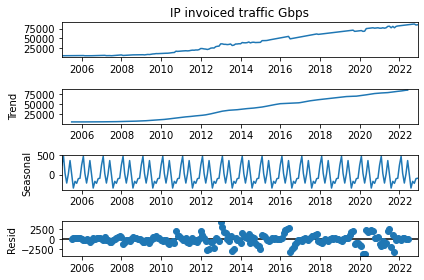

In [20]:
a = seasonal_decompose(df["IP invoiced traffic Gbps"], model = "add")
a.plot();

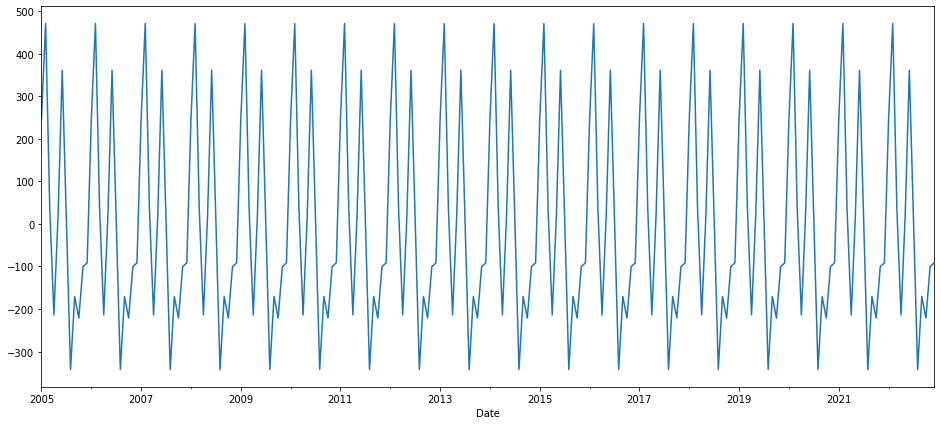

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize = (16,7))
a.seasonal.plot();

<AxesSubplot:xlabel='Date'>

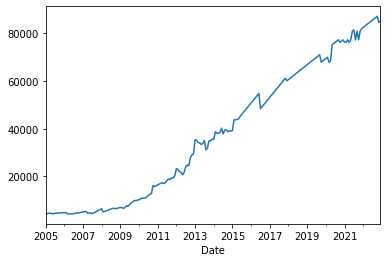

In [22]:
df['IP invoiced traffic Gbps'].plot()

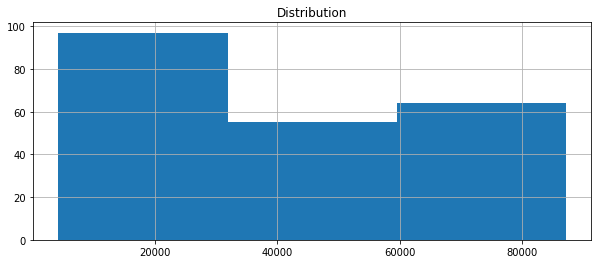

In [23]:
#df.columns = df.columns.str.replace('IP monthly invoiced traffic -Gbps', 'IP')
plt.close('all')
#plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
df["IP invoiced traffic Gbps"].hist(bins=3, ax=ax)
plt.title('Distribution')
plt.show()

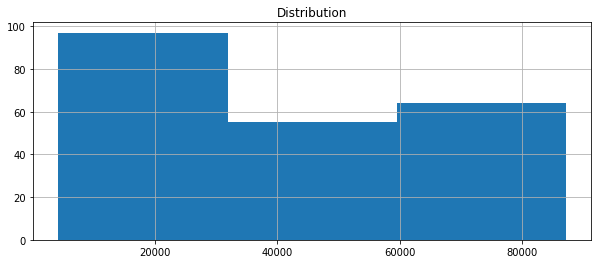

In [24]:
plt.close('all')
#plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,4))
df["IP invoiced traffic Gbps"].hist(bins=3, ax=ax)
plt.title('Distribution')
plt.show()


In [25]:
#splitting dataset into train and test split
split_percent = 0.80
split = int(len(df)*split_percent)
train_data,test_data = df[:split],df[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]
model = ExponentialSmoothing(train_data['IP invoiced traffic Gbps'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
smoothing_pred=model.forecast(len(date_test)).rename("Predictions")

smoothing_rmse_error = rmse(test_data['IP invoiced traffic Gbps'], smoothing_pred)
smoothing_mse_error = smoothing_rmse_error**2
mean_value = df['IP invoiced traffic Gbps'].mean()
print("test dataset")
print(f'MSE Error: {smoothing_mse_error}\nRMSE Error: {smoothing_rmse_error}\nMean: {mean_value}')

# save the model to disk
filename = path + 'Smoothing_model.sav'
joblib.dump(model, filename)

test dataset
MSE Error: 530351547.0570261
RMSE Error: 23029.362714956445
Mean: 37820.17798669216


['C:/Users/lnzb7292/Desktop/BPM/Power BI IC Reports/Smoothing_model.sav']

<AxesSubplot:title={'center':'OTI Traffic'}, xlabel='Date'>

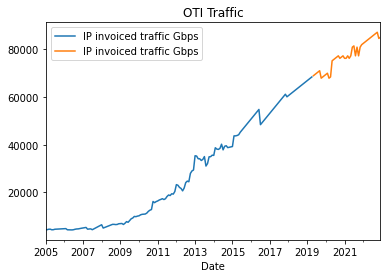

In [27]:
plt.title('OTI Traffic')
train_data['IP invoiced traffic Gbps'].plot(legend=True)
test_data['IP invoiced traffic Gbps'].plot(legend=True)

<AxesSubplot:title={'center':'OTI Traffic'}, xlabel='Date'>

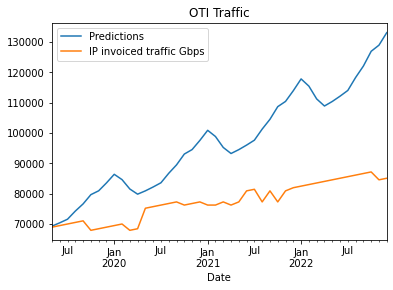

In [28]:
plt.title('OTI Traffic')
smoothing_pred.plot(legend = True) 
test_data['IP invoiced traffic Gbps'].plot(legend = True) 

In [29]:
loaded_model = joblib.load(filename)
range = pd.date_range('2023-01-01',periods=24,freq='MS')
predictions = loaded_model.forecast(24)
predictions_range = pd.DataFrame({'IP invoiced traffic Gbps':predictions,'Date':range})
predictions_range.set_axis(predictions_range['Date'], inplace=True)
predictions_range.index.names = ['index']
df1=df.append(predictions_range)
df3=df1
df3.Date = pd.to_datetime(df3.Date)
df3 = df3.groupby('Date')["IP invoiced traffic Gbps"].sum()
df3 = pd.DataFrame(df3.groupby(df3.index.to_period('y')).cumsum().reset_index().to_records())
df3.columns=['index','Date','Cumul_IP']
df3=df3.drop('index', axis=1)

df=pd.merge(df1,df3, on=["Date", "Date"])
df = df.set_index("Date")
df

Date  IP invoiced traffic Gbps   IP REVENUES      Cumul_IP
0   2005-01-01               4358.333314  2.839778e+06  4.358333e+03
1   2005-02-01               4394.800804  2.863318e+06  8.753134e+03
2   2005-03-01               4590.296209  2.749129e+06  1.334343e+04
3   2005-04-01               4613.447789  2.980226e+06  1.795688e+04
4   2005-05-01               4358.333314  2.839778e+06  2.231521e+04
..         ...                       ...           ...           ...
235 2024-08-01              97538.703156           NaN  7.078895e+05
236 2024-09-01             100863.446768           NaN  8.087529e+05
237 2024-10-01              98822.140690           NaN  9.075751e+05
238 2024-11-01              95211.508085           NaN  1.002787e+06
239 2024-12-01              93215.498997           NaN  1.096002e+06

[240 rows x 4 columns]

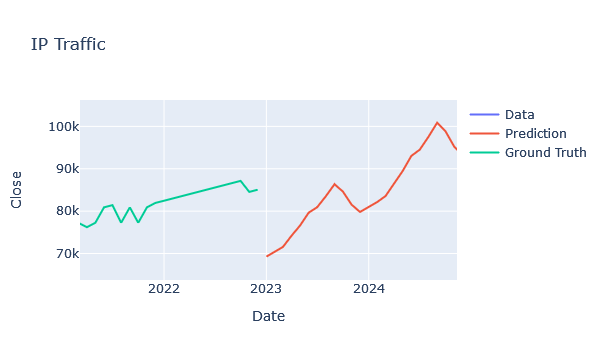

In [30]:
import plotly.graph_objs as go
#train_data = train_data.reshape((-1))
#test_data = test_data.reshape((-1))
#prediction = test_predict.reshape((-1))
trace1 = go.Scatter(
    x = date_train,
    y = train_data['IP invoiced traffic Gbps'],
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = predictions_range['Date'],
    y = predictions_range['IP invoiced traffic Gbps'],
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = test_data['IP invoiced traffic Gbps'],
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "IP Traffic",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1,trace2, trace3], layout=layout)
fig.show()